In [1]:
# Cell 1: Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Cell 2: Đọc dữ liệu từ file CSV và tiền xử lý
file_name = r"C:\Users\Admin\Downloads\VN Index Historical Data.csv"  # Thay đường dẫn phù hợp
df = pd.read_csv(file_name)

# Chuyển đổi cột Date sang kiểu datetime và sắp xếp theo ngày
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

# Chuyển đổi các cột số: Close, Open, High, Low
for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

print(df.head())

        Date   Close    Open    High     Low    Vol. Change %
0 2010-01-28  481.76  484.67  487.81  481.47  23.07K   -0.96%
1 2010-01-29  481.96  481.49  484.15  477.11  26.56K    0.04%
2 2010-02-01  486.95  482.93  486.95  481.84  23.14K    1.04%
3 2010-02-02  487.93  489.62  490.86  486.24  27.41K    0.20%
4 2010-02-03  495.48  490.32  495.85  490.12  26.57K    1.55%


In [7]:
# Cell 3: Định nghĩa hàm tính EMA, RSI và sinh tín hiệu dựa trên dữ liệu của ngày trước (Prev_*)
def add_indicators(data, ema_short=21, ema_long=44, rsi_period=34):
    d = data.copy()
    d[f'EMA{ema_short}'] = d['Close'].ewm(span=ema_short, adjust=False).mean()
    d[f'EMA{ema_long}'] = d['Close'].ewm(span=ema_long, adjust=False).mean()
    delta = d['Close'].diff()
    gain = delta.where(delta>0, 0).rolling(window=rsi_period, min_periods=1).mean()
    loss = -delta.where(delta<0, 0).rolling(window=rsi_period, min_periods=1).mean()
    d['RSI'] = 100 - (100/(1+gain/loss))
    # Tạo các cột Prev_* dùng để tránh look-ahead bias
    d['Prev_Close'] = d['Close'].shift(1)
    d[f'Prev_EMA{ema_short}'] = d[f'EMA{ema_short}'].shift(1)
    d[f'Prev_EMA{ema_long}'] = d[f'EMA{ema_long}'].shift(1)
    d['Prev_RSI'] = d['RSI'].shift(1)
    return d

def generate_signals(data, rsi_buy=50, rsi_sell=50):
    # Sinh tín hiệu dựa trên dữ liệu của ngày trước (Prev_*)
    def sig(row):
        if pd.isna(row['Prev_Close']) or pd.isna(row['Prev_EMA21']) or pd.isna(row['Prev_EMA44']) or pd.isna(row['Prev_RSI']):
            return 0
        if row['Prev_Close'] > row['Prev_EMA21'] and row['Prev_Close'] > row['Prev_EMA44'] and row['Prev_RSI'] > rsi_buy:
            return 1
        elif row['Prev_Close'] < row['Prev_EMA21'] and row['Prev_Close'] < row['Prev_EMA44'] and row['Prev_RSI'] < rsi_sell:
            return -1
        else:
            return 0
    data['Signal'] = data.apply(sig, axis=1)
    return data


In [ ]:
def pipeline(data):
    d = add_indicators(data)
    d.dropna(inplace=True)
    d = generate_signals(d)
    return d

df = pipeline(df)

In [8]:
# Cell 4: Chia dữ liệu theo TimeSeriesSplit và huấn luyện mô hình Random Forest
df['Predicted_Signal'] = np.nan
ts = TimeSeriesSplit(n_splits=5)
features = ['Close', 'EMA21', 'EMA44', 'RSI']  # Sử dụng các giá trị hiện tại để huấn luyện

for train_idx, test_idx in ts.split(df):
    X_train, X_test = df.iloc[train_idx][features], df.iloc[test_idx][features]
    y_train = df.iloc[train_idx]['Signal']
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    df.iloc[test_idx, df.columns.get_loc('Predicted_Signal')] = model.predict(X_test)

In [5]:
# Cell 5: Mô phỏng giao dịch sử dụng giá mở cửa của phiên kế tiếp
trades = []
in_position = False
pos = 0
entry_price = None
entry_date = None

i = 0
while i < len(df)-1:
    sig = df.loc[df.index[i], 'Predicted_Signal']
    next_open = df.loc[df.index[i+1], 'Open']
    next_date = df.loc[df.index[i+1], 'Date']
    
    if not in_position and sig in [1, -1]:
        in_position = True
        pos = sig
        entry_price = next_open
        entry_date = next_date
    elif in_position and sig != pos and sig != 0:
        exit_price = next_open
        exit_date = next_date
        ret = (exit_price - entry_price)/entry_price if pos==1 else (entry_price - exit_price)/entry_price
        trades.append({'Entry Date': entry_date, 'Exit Date': exit_date,
                       'Entry Price': entry_price, 'Exit Price': exit_price,
                       'Position': pos, 'Return': ret})
        in_position = False
        pos = 0
    i += 1

if in_position:
    exit_price = df.loc[df.index[-1], 'Close']
    exit_date = df.loc[df.index[-1], 'Date']
    ret = (exit_price - entry_price)/entry_price if pos==1 else (entry_price - exit_price)/entry_price
    trades.append({'Entry Date': entry_date, 'Exit Date': exit_date,
                   'Entry Price': entry_price, 'Exit Price': exit_price,
                   'Position': pos, 'Return': ret})

print("Các giao dịch:")
for t in trades:
    print(t)

Các giao dịch:
{'Entry Date': Timestamp('2012-08-15 00:00:00'), 'Exit Date': Timestamp('2012-08-24 00:00:00'), 'Entry Price': 429.96, 'Exit Price': 379.45, 'Position': 1.0, 'Return': -0.11747604428318911}
{'Entry Date': Timestamp('2012-08-28 00:00:00'), 'Exit Date': Timestamp('2012-10-17 00:00:00'), 'Entry Price': 381.06, 'Exit Price': 399.22, 'Position': -1.0, 'Return': -0.04765653702828957}
{'Entry Date': Timestamp('2012-11-05 00:00:00'), 'Exit Date': Timestamp('2012-12-19 00:00:00'), 'Entry Price': 372.39, 'Exit Price': 395.84, 'Position': -1.0, 'Return': -0.06297161577915623}
{'Entry Date': Timestamp('2012-12-20 00:00:00'), 'Exit Date': Timestamp('2013-04-22 00:00:00'), 'Entry Price': 399.13, 'Exit Price': 471.81, 'Position': 1.0, 'Return': 0.1820960589281688}
{'Entry Date': Timestamp('2013-04-23 00:00:00'), 'Exit Date': Timestamp('2013-04-24 00:00:00'), 'Entry Price': 470.59, 'Exit Price': 474.48, 'Position': -1.0, 'Return': -0.008266219001678836}
{'Entry Date': Timestamp('2013-04

Lợi nhuận tích lũy của chiến lược: 2.4271


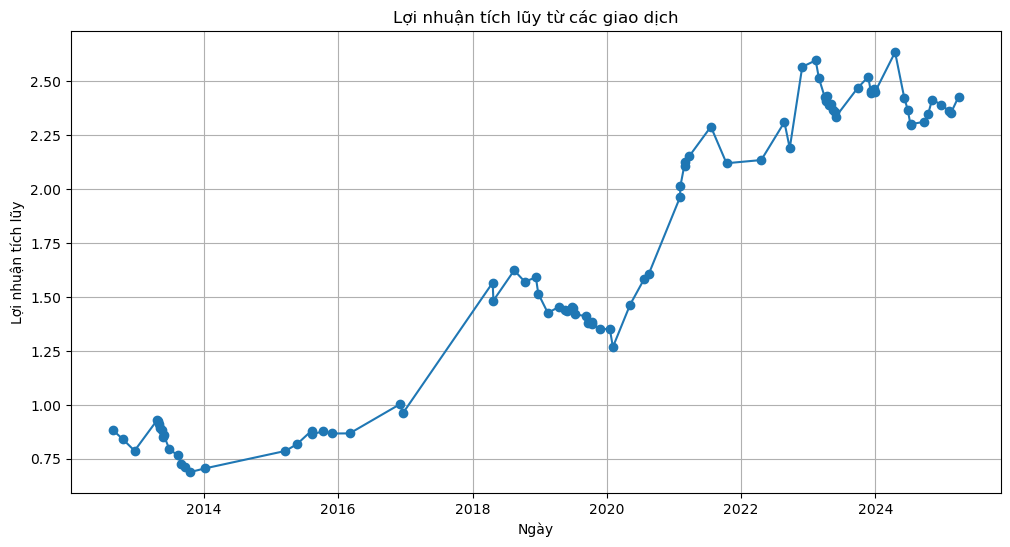

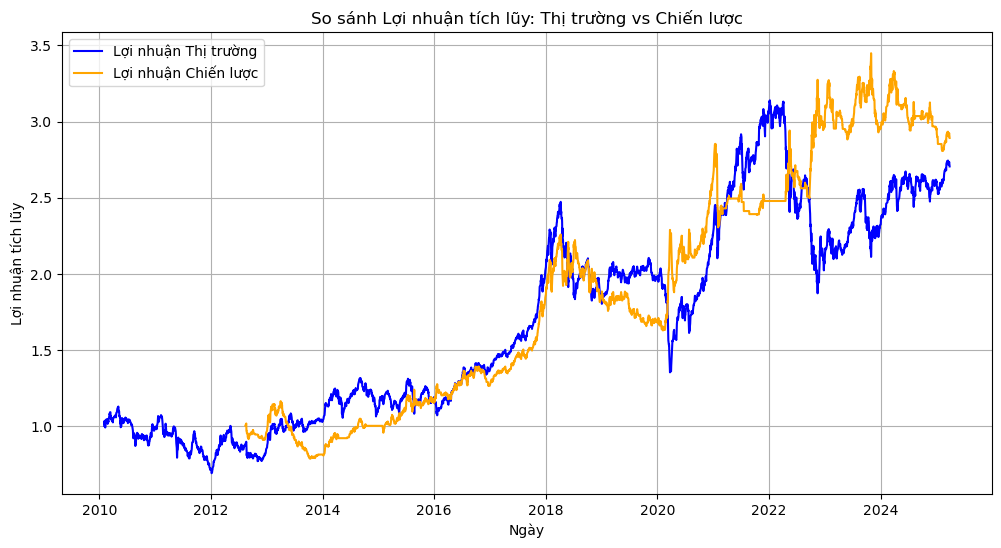

In [9]:
# Cell 6: Tính hiệu suất và vẽ biểu đồ lợi nhuận tích lũy của chiến lược
cum_return = 1.0
for t in trades:
    cum_return *= (1 + t['Return'])
print(f"Lợi nhuận tích lũy của chiến lược: {cum_return:.4f}")

# Tính và vẽ biểu đồ lợi nhuận tích lũy từ các giao dịch
trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    trades_df['Cumulative Return'] = (1 + trades_df['Return']).cumprod()
    plt.figure(figsize=(12,6))
    plt.plot(trades_df['Exit Date'], trades_df['Cumulative Return'], marker='o')
    plt.title('Lợi nhuận tích lũy từ các giao dịch')
    plt.xlabel('Ngày')
    plt.ylabel('Lợi nhuận tích lũy')
    plt.grid(True)
    plt.show()

# So sánh với lợi nhuận thị trường
df['Daily_Return'] = df['Close'].pct_change()
df['Cum_Market_Return'] = (1+df['Daily_Return']).cumprod()
df['Strategy_Return_Signal'] = df['Daily_Return'] * df['Predicted_Signal'].shift(1)
df['Cum_Strategy_Return_Signal'] = (1+df['Strategy_Return_Signal']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Cum_Market_Return'], label='Lợi nhuận Thị trường', color='blue')
plt.plot(df['Date'], df['Cum_Strategy_Return_Signal'], label='Lợi nhuận Chiến lược', color='orange')
plt.title('So sánh Lợi nhuận tích lũy: Thị trường vs Chiến lược')
plt.xlabel('Ngày')
plt.ylabel('Lợi nhuận tích lũy')
plt.legend()
plt.grid(True)
plt.show()